In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau  # add import
from torchvision.transforms import v2 as T
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from ShroomDataset import ShroomDataset, ClassBalancedBatchSampler
from ShroomCNN import ShroomCNNAttentive, AuxSpeciesHead
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, top_k_accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from PIL import Image, ImageOps
import os
from tqdm.auto import tqdm
from contextlib import nullcontext

data_path = './data/'

train_meta = pd.read_csv(os.path.join(data_path, 'train.csv'))#.iloc[:1000]
val_meta = pd.read_csv(os.path.join(data_path, 'val.csv'))
test_meta = pd.read_csv(os.path.join(data_path, 'test.csv'))


In [2]:
IMG_SIZE = 256  # try 256/288 for accuracy later
mean = (0.485, 0.456, 0.406)  # TODO: compute dataset stats
std  = (0.229, 0.224, 0.225)

train_tf = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.75, 1.0), ratio=(0.8, 1.25), antialias=False),
    T.RandomHorizontalFlip(0.5),
    T.RandomApply([T.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05))], p=0.35),
    T.RandomApply([T.ColorJitter(0.2, 0.2, 0.2, 0.05)], p=0.35),
    T.RandomErasing(p=0.1, scale=(0.02, 0.1), ratio=(0.3, 3.3)),  # new, mild
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean, std),
])
val_tf = T.Compose([
    T.Resize(IMG_SIZE, antialias=False),
    T.CenterCrop(IMG_SIZE),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean, std),
])

train_ds = ShroomDataset(train_meta, data_path, transform=train_tf)
val_ds   = ShroomDataset(val_meta,   data_path, transform=val_tf, label2idx=train_ds.label2idx)
test_ds  = ShroomDataset(test_meta,  data_path, transform=val_tf, label2idx=train_ds.label2idx)

num_classes = len(train_ds.label2idx)
train_labels = np.asarray(train_ds.labels, dtype=np.int64)
idx2label = {v: k for k,v in train_ds.label2idx.items()}

counts = np.bincount(train_labels, minlength=num_classes)
alpha = 0.5
class_w = (np.maximum(counts, 1) ** -alpha)
sample_w = class_w[train_labels]

samples_per_epoch = 150_000
sampler = WeightedRandomSampler(
    weights=torch.DoubleTensor(sample_w),
    num_samples=samples_per_epoch,
    replacement=True
)

print(f"# classes: {num_classes}")
BATCH = 128

# MPS: pin_memory has no benefit; keep False
DEVICE = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')
import os
NUM_WORKERS = min(8, max(1, (os.cpu_count() or 4)//2))
PIN = (DEVICE == "cuda")  # False on MPS
PREFETCH = 2 if NUM_WORKERS > 0 else None

cls_train_loader_kwargs = dict(
    batch_size=BATCH,
    sampler=sampler,
    num_workers=NUM_WORKERS,
    persistent_workers=(NUM_WORKERS > 0),
    pin_memory=PIN,
)
if PREFETCH is not None:
    cls_train_loader_kwargs["prefetch_factor"] = PREFETCH

cls_val_loader_kwargs = dict(
    batch_size=BATCH,
    shuffle=False,
    num_workers=NUM_WORKERS,
    persistent_workers=(NUM_WORKERS > 0),
    pin_memory=PIN,
)
if PREFETCH is not None:
    cls_val_loader_kwargs["prefetch_factor"] = PREFETCH

cls_test_loader_kwargs = dict(
    batch_size=BATCH,
    shuffle=False,
    num_workers=NUM_WORKERS,
    persistent_workers=(NUM_WORKERS > 0),
    pin_memory=PIN,
)
if PREFETCH is not None:
    cls_test_loader_kwargs["prefetch_factor"] = PREFETCH

cls_train_loader = DataLoader(train_ds, **cls_train_loader_kwargs)
cls_val_loader   = DataLoader(val_ds,   **cls_val_loader_kwargs)
cls_test_loader  = DataLoader(test_ds,  **cls_test_loader_kwargs)

# classes: 169


In [3]:
class EncoderFromBackbone(nn.Module):
    def __init__(self, backbone: nn.Module, feat_bn: bool = True):
        super().__init__()
        self.stem = getattr(backbone, 'stem', nn.Identity())
        self.body = backbone.model
        self.pool = backbone.global_pool
        self.flatten = nn.Flatten()

        # Prefer feature dim provided by backbone; fallback to first Linear in classifier.
        out_dim = getattr(backbone, 'feat_dim', None)
        if out_dim is None:
            first_linear = None
            for m in getattr(backbone, 'classifier', []):
                if isinstance(m, nn.Linear):
                    first_linear = m
                    break
            assert first_linear is not None, "Couldn't infer feature dim: set backbone.feat_dim or start classifier with a Linear."
            out_dim = first_linear.in_features

        self.out_dim = int(out_dim)
        self.bn = nn.BatchNorm1d(self.out_dim) if feat_bn else nn.Identity()

    def forward(self, x):
        x = self.stem(x)
        x = self.body(x)
        x = self.pool(x)
        x = self.flatten(x)
        x = x.contiguous()
        x = self.bn(x)
        return x

In [4]:
# must match the pretrain backbone config
blocks = [
    (64,   True,  False, True,  True),   # SE only
    (128,  True,  False, True,  True),
    (256,  True,  True,  True,  True),   # CBAM here
    (320,  True,  False, True,  True),
]

def build_backbone():
    # num_classes passed here is irrelevant for the encoder, but ctor needs it
    return ShroomCNNAttentive(in_ch=3, block_cfgs=blocks, mlp_units=[1024,512], num_classes=num_classes)

In [5]:
ENC_PATH = "encoder_supcon_with_aux.pth"  # path to the file you saved
enc_state_dict = torch.load(ENC_PATH, map_location="cpu")

# derive feat_dim from the backbone itself (robust across notebooks)
_tmp = EncoderFromBackbone(build_backbone())
feat_dim = _tmp.out_dim
del _tmp
print("feat_dim =", feat_dim)

feat_dim = 320


In [6]:
class LinearProbe(nn.Module):
    def __init__(self, backbone_ctor, encoder_state_dict, feat_dim, num_classes):
        super().__init__()
        backbone = backbone_ctor()
        self.encoder = EncoderFromBackbone(backbone)
        self.encoder.load_state_dict(encoder_state_dict, strict=True)
        for p in self.encoder.parameters(): 
            p.requires_grad = False
        try:
            self.encoder = self.encoder.to(memory_format=torch.channels_last)
        except Exception:
            pass

        self.head = nn.Sequential(
            nn.Linear(feat_dim, 512), nn.ReLU(inplace=True), nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        with torch.no_grad():
            f = self.encoder(x)
        return self.head(f)
    
class ClassifierWithEncoder(nn.Module):
    def __init__(self, backbone_ctor, encoder_state_dict, feat_dim, num_classes):
        super().__init__()
        backbone = backbone_ctor()
        self.encoder = EncoderFromBackbone(backbone)
        self.encoder.load_state_dict(encoder_state_dict, strict=True)
        try:
            self.encoder = self.encoder.to(memory_format=torch.channels_last)
        except Exception:
            pass
        self.head = nn.Sequential(
            nn.Linear(feat_dim, 512), nn.ReLU(inplace=True), nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def freeze_encoder(self):
        for p in self.encoder.parameters(): p.requires_grad = False

    def unfreeze_last_k(self, k=2, bn_affine=True, bn_stats_train=False):
        # unfreeze last k blocks in encoder.body (Sequential of ConvAttnBlocks / downsample convs)
        modules = list(self.encoder.body.children())
        for m in modules[-k:]:
            for p in m.parameters(): p.requires_grad = True

        # BN handling: allow affine to learn; keep running stats frozen (eval) if bn_stats_train=False
        for m in self.encoder.modules():
            if isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                if bn_affine:
                    if m.weight is not None: m.weight.requires_grad = True
                    if m.bias  is not None: m.bias.requires_grad  = True
                if not bn_stats_train:
                    m.eval()   # keep running stats fixed for small batches
    def unfreeze_all(self, bn_affine=True, bn_stats_train=False):
        for p in self.encoder.parameters():
            p.requires_grad = True
        for m in self.encoder.modules():
            if isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                if bn_affine:
                    if m.weight is not None: m.weight.requires_grad = True
                    if m.bias  is not None: m.bias.requires_grad  = True
                if not bn_stats_train:
                    m.eval()
                    
    def forward(self, x):
        f = self.encoder(x)     # encoder is allowed to grad if unfrozen
        return self.head(f)

In [7]:
import math
import numpy as np
import torch

def _rand_bbox(H, W, lam, device):
    """CutMix bbox. lam is area keep ratio; we cut area (1-lam)."""
    cut_rat = math.sqrt(1.0 - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform center
    cx = torch.randint(0, W, (1,), device=device).item()
    cy = torch.randint(0, H, (1,), device=device).item()

    x1 = max(cx - cut_w // 2, 0)
    y1 = max(cy - cut_h // 2, 0)
    x2 = min(cx + cut_w // 2, W)
    y2 = min(cy + cut_h // 2, H)
    return x1, y1, x2, y2

def mixup_or_cutmix(x, y, mixup_alpha=0.2, cutmix_alpha=1.0, p_cutmix=0.3):
    """
    Returns:
      x_aug, y_a, lam, y_b
    If CutMix not triggered/supported, falls back to MixUp (if alpha>0), else identity.
    """
    if (p_cutmix > 0.0 and cutmix_alpha > 0.0) and (np.random.rand() < p_cutmix):
        # ---- CutMix ----
        lam = np.random.beta(cutmix_alpha, cutmix_alpha)
        B, C, H, W = x.shape
        idx = torch.randperm(B, device=x.device)
        x1, y1, x2, y2 = _rand_bbox(H, W, lam, x.device)
        x[:, :, y1:y2, x1:x2] = x[idx, :, y1:y2, x1:x2]
        # adjust lam to the exact pixel ratio actually replaced
        lam = 1.0 - ((x2 - x1) * (y2 - y1) / float(H * W))
        return x, y, lam, y[idx]
    elif mixup_alpha and mixup_alpha > 0.0:
        # ---- MixUp ----
        lam = np.random.beta(mixup_alpha, mixup_alpha)
        idx = torch.randperm(x.size(0), device=x.device)
        x = lam * x + (1.0 - lam) * x[idx]
        return x, y, lam, y[idx]
    else:
        # identity
        return x, y, 1.0, y

In [8]:
from torch.optim import AdamW
from math import pi


def train_probe(model, train_loader, val_loader, epochs=15, base_lr=1e-3, weight_decay=1e-4,
                mixup_alpha=0.2, mixup_alpha_end=0.05,    # decays linearly to end
                cutmix_alpha=1.0, p_cutmix=0.25):
    device = DEVICE
    model.to(device)

    cw = torch.tensor(class_w, dtype=torch.float32, device=device)
    criterion = nn.CrossEntropyLoss(weight=cw, label_smoothing=0.1)

    opt  = AdamW(model.head.parameters(), lr=base_lr, weight_decay=weight_decay)

    steps_per_epoch = max(1, len(train_loader))
    warmup_steps = steps_per_epoch * 1
    total_steps  = steps_per_epoch * epochs
    def lr_lambda(step):
        if step < warmup_steps:
            return (step + 1) / max(1, warmup_steps)
        t = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        return 0.5 * (1 + np.cos(np.pi * t))
    sched = optim.lr_scheduler.LambdaLR(opt, lr_lambda=lr_lambda)

    use_amp = (device == "cuda")
    if use_amp:
        bf16_ok = torch.cuda.is_bf16_supported()
        amp_dtype = torch.bfloat16 if bf16_ok else torch.float16
        scaler = torch.amp.GradScaler(enabled=not bf16_ok)
    else:
        amp_dtype = None
        scaler = None

    best_loss=float('inf'); best_sd=None
    history = []
    global_step = 0

    for ep in range(1, epochs+1):
        model.train(); runL=acc=n=0
        for x,y in tqdm(train_loader, desc=f"Probe {ep}/{epochs}", leave=False):
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            # Linearly decay mixup over training
            frac = min(1.0, global_step / max(1, total_steps - 1))
            mix_now = mixup_alpha + (mixup_alpha_end - mixup_alpha) * frac
            x_aug, ya, lam, yb = mixup_or_cutmix(x, y, mixup_alpha=mix_now,
                                                 cutmix_alpha=cutmix_alpha, p_cutmix=p_cutmix)

            opt.zero_grad(set_to_none=True)
            if use_amp:
                with torch.autocast(device_type="cuda", dtype=amp_dtype):
                    out = model(x_aug)
                    loss = lam*criterion(out, ya) + (1-lam)*criterion(out, yb)
                scaler.scale(loss).backward()
                scaler.step(opt); scaler.update()
            else:
                out = model(x_aug)
                loss = lam*criterion(out, ya) + (1-lam)*criterion(out, yb)
                loss.backward(); opt.step()

            sched.step(); global_step += 1

            runL += float(loss)*y.size(0); acc += (out.argmax(1)==y).sum().item(); n += y.size(0)

        trL, trA = runL/n, acc/n

        model.eval(); vL=vA=m=0
        with torch.no_grad():
            for x,y in val_loader:
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                out = model(x)
                vL += float(criterion(out,y))*y.size(0)
                vA += (out.argmax(1)==y).sum().item(); m += y.size(0)
        vL, vA = vL/m, vA/m
        if vL < best_loss - 1e-4:
            best_loss=vL; best_sd={k:v.cpu().clone() for k,v in model.state_dict().items()}
        curr_lr = sched.get_last_lr()[0]
        print(f"Epoch {ep:3d}/{epochs:3d} | Train {trL:.4f}/{trA:.4f} | Val {vL:.4f}/{vA:.4f} | LR {curr_lr:.2e}")
        history.append((trL, trA, vL, vA))
        if DEVICE == "mps": torch.mps.empty_cache()

    if best_sd: model.load_state_dict(best_sd)
    return model, history

def fine_tune(model, train_loader, val_loader, epochs=10,
              lr_head=5e-4, lr_enc=5e-5,
              weight_decay_head=1e-4, weight_decay_enc=5e-5,
              mixup_alpha=0.2, mixup_alpha_end=0.05,
              cutmix_alpha=1.0, p_cutmix=0.25):
    device = DEVICE
    model.to(device)

    cw = torch.tensor(class_w, dtype=torch.float32, device=device)
    criterion = nn.CrossEntropyLoss(weight=cw, label_smoothing=0.1)

    # encoder param groups
    enc_params_decay, enc_params_nod = [], []
    for m in model.encoder.modules():
        for n, p in m.named_parameters(recurse=False):
            if not p.requires_grad: 
                continue
            if isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.GroupNorm, nn.LayerNorm)) or n.endswith("bias"):
                enc_params_nod.append(p)
            else:
                enc_params_decay.append(p)
    head_params = list(model.head.parameters())

    param_groups = []
    if enc_params_decay: param_groups.append({"params": enc_params_decay, "lr": lr_enc, "weight_decay": weight_decay_enc})
    if enc_params_nod:   param_groups.append({"params": enc_params_nod,   "lr": lr_enc, "weight_decay": 0.0})
    param_groups.append({"params": head_params, "lr": lr_head, "weight_decay": weight_decay_head})

    opt = optim.AdamW(param_groups)

    steps_per_epoch = max(1, len(train_loader))
    warmup_steps = steps_per_epoch * 1
    total_steps  = steps_per_epoch * epochs
    def lr_lambda(step):
        if step < warmup_steps: return (step + 1) / max(1, warmup_steps)
        t = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        return 0.5 * (1 + np.cos(np.pi * t))
    sched = optim.lr_scheduler.LambdaLR(opt, lr_lambda=lr_lambda)

    use_amp = (DEVICE == "cuda")
    if use_amp:
        bf16_ok = torch.cuda.is_bf16_supported()
        amp_dtype = torch.bfloat16 if bf16_ok else torch.float16
        scaler = torch.amp.GradScaler(enabled=not bf16_ok)
    else:
        amp_dtype = None
        scaler = None

    best = {"vloss": float("inf"), "sd": None}
    hist = []
    global_step = 0

    for ep in range(1, epochs+1):
        model.train(); runL=acc=n=0

        for x,y in tqdm(train_loader, desc=f"FT {ep}/{epochs}", leave=False):
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            # linear decay of mixup strength to end
            frac = min(1.0, global_step / max(1, total_steps - 1))
            mix_now = mixup_alpha + (mixup_alpha_end - mixup_alpha) * frac
            x_aug, ya, lam, yb = mixup_or_cutmix(
                x, y,
                mixup_alpha=mix_now,
                cutmix_alpha=cutmix_alpha, p_cutmix=p_cutmix
            )

            opt.zero_grad(set_to_none=True)
            if use_amp:
                with torch.autocast(device_type="cuda", dtype=amp_dtype):
                    out  = model(x_aug)
                    loss = lam*criterion(out, ya) + (1-lam)*criterion(out, yb)
                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(opt); scaler.update()
            else:
                out  = model(x_aug)
                loss = lam*criterion(out, ya) + (1-lam)*criterion(out, yb)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                opt.step()

            sched.step(); global_step += 1

            runL += float(loss)*y.size(0); acc += (out.argmax(1)==y).sum().item(); n += y.size(0)

        trL, trA = runL/max(1,n), acc/max(1,n)

        # validation
        model.eval(); vL=vA=m=0
        with torch.no_grad():
            for x,y in val_loader:
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                out = model(x)
                vL += float(criterion(out,y))*y.size(0)
                vA += (out.argmax(1)==y).sum().item(); m += y.size(0)
        vL, vA = vL/max(1,m), vA/max(1,m)

        if vL < best["vloss"] - 1e-4:
            best["vloss"] = vL
            best["sd"] = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}

        print(f"Epoch {ep:2d}/{epochs:2d} | Train {trL:.4f}/{trA:.4f} | Val {vL:.4f}/{vA:.4f} | "
              f"LR(enc/head) {[pg['lr'] for pg in opt.param_groups[:-1]] + [opt.param_groups[-1]['lr']]}")

        hist.append((trL,trA,vL,vA))
        if DEVICE == "mps": torch.mps.empty_cache()

    if best["sd"] is not None:
        model.load_state_dict(best["sd"])
    return model, hist

In [9]:
@torch.no_grad()
def evaluate_classifier(model, loader, classes, tta_hflip=True):
    device = DEVICE
    model.to(device).eval()
    y_true, y_pred, y_logits = [], [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True).contiguous(memory_format=torch.channels_last)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        if tta_hflip:
            xf = torch.flip(x, dims=[-1])
            logits = logits + model(xf)
            logits = logits * 0.5

        preds = logits.argmax(1)
        y_logits.append(logits.cpu()); y_pred.append(preds.cpu()); y_true.append(y.cpu())
    y_true  = torch.cat(y_true).numpy()
    y_pred  = torch.cat(y_pred).numpy()
    y_logits= torch.cat(y_logits).numpy()
    num_classes = len(classes)
    return dict(
        top1=accuracy_score(y_true, y_pred),
        top5=top_k_accuracy_score(y_true, y_logits, k=min(3, num_classes), labels=list(range(num_classes))),
        f1=f1_score(y_true, y_pred, average='weighted', zero_division=0),
        precision=precision_score(y_true, y_pred, average='weighted', zero_division=0),
        recall=recall_score(y_true, y_pred, average='weighted', zero_division=0),
    )

Probe 1/16:   0%|          | 0/1172 [00:09<?, ?it/s]

Epoch   1/ 16 | Train 3.0913/0.2915 | Val 2.0986/0.6305 | LR 5.00e-03


Probe 2/16:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch   2/ 16 | Train 3.0162/0.3201 | Val 2.0485/0.6642 | LR 4.95e-03


Probe 3/16:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch   3/ 16 | Train 2.9614/0.3230 | Val 2.0266/0.6709 | LR 4.78e-03


Probe 4/16:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch   4/ 16 | Train 2.9169/0.3155 | Val 2.0425/0.6642 | LR 4.52e-03


Probe 5/16:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch   5/ 16 | Train 2.8498/0.3321 | Val 2.0138/0.6755 | LR 4.17e-03


Probe 6/16:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch   6/ 16 | Train 2.8441/0.3193 | Val 2.0438/0.6628 | LR 3.75e-03


Probe 7/16:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch   7/ 16 | Train 2.8012/0.3282 | Val 2.0214/0.6689 | LR 3.27e-03


Probe 8/16:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch   8/ 16 | Train 2.7177/0.3573 | Val 1.9931/0.6754 | LR 2.76e-03


Probe 9/16:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch   9/ 16 | Train 2.6818/0.3521 | Val 1.9514/0.6857 | LR 2.24e-03


Probe 10/16:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  10/ 16 | Train 2.5402/0.3555 | Val 1.8988/0.7015 | LR 1.73e-03


Probe 11/16:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  11/ 16 | Train 2.5063/0.3636 | Val 1.8867/0.6985 | LR 1.25e-03


Probe 12/16:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  12/ 16 | Train 2.4689/0.3796 | Val 1.8450/0.7076 | LR 8.27e-04


Probe 13/16:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  13/ 16 | Train 2.4473/0.3576 | Val 1.8451/0.7091 | LR 4.77e-04


Probe 14/16:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  14/ 16 | Train 2.3701/0.3679 | Val 1.8376/0.7116 | LR 2.16e-04


Probe 15/16:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  15/ 16 | Train 2.2919/0.3914 | Val 1.8254/0.7116 | LR 5.46e-05


Probe 16/16:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  16/ 16 | Train 2.2986/0.3859 | Val 1.8176/0.7140 | LR 0.00e+00


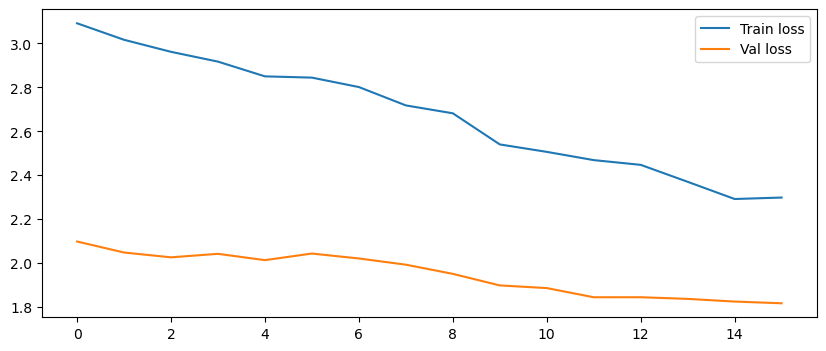

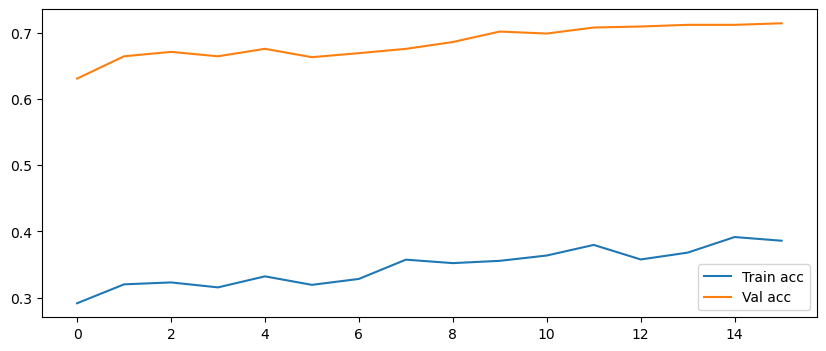

In [10]:
probe = LinearProbe(build_backbone, enc_state_dict, feat_dim, num_classes=num_classes)
probe, history = train_probe(probe, cls_train_loader, cls_val_loader, epochs=16, base_lr=5e-3)

plt.figure(figsize=(10,4))
plt.plot([h[0] for h in history], label='Train loss')
plt.plot([h[2] for h in history], label='Val loss')
plt.legend(); plt.show()
plt.figure(figsize=(10,4))
plt.plot([h[1] for h in history], label='Train acc')
plt.plot([h[3] for h in history], label='Val acc')
plt.legend(); plt.show()



Loaded probe head into fine-tune model.


FT 1/13:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  1/13 | Train 2.4106/0.3691 | Val 1.7288/0.7358 | LR(enc/head) [0.0001, 0.0001, 0.001]


FT 2/13:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  2/13 | Train 2.2769/0.3808 | Val 1.7040/0.7485 | LR(enc/head) [9.829629131445342e-05, 9.829629131445342e-05, 0.0009829629131445341]


FT 3/13:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  3/13 | Train 2.1836/0.4142 | Val 1.6525/0.7606 | LR(enc/head) [9.330127018922194e-05, 9.330127018922194e-05, 0.0009330127018922195]


FT 4/13:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  4/13 | Train 2.1120/0.4155 | Val 1.6307/0.7617 | LR(enc/head) [8.535533905932738e-05, 8.535533905932738e-05, 0.0008535533905932737]


FT 5/13:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  5/13 | Train 2.0281/0.4010 | Val 1.6146/0.7671 | LR(enc/head) [7.500000000000001e-05, 7.500000000000001e-05, 0.00075]


FT 6/13:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  6/13 | Train 1.9616/0.4352 | Val 1.5979/0.7745 | LR(enc/head) [6.294095225512603e-05, 6.294095225512603e-05, 0.0006294095225512603]


FT 7/13:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  7/13 | Train 1.9969/0.4235 | Val 1.5860/0.7754 | LR(enc/head) [5e-05, 5e-05, 0.0005]


FT 8/13:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  8/13 | Train 1.8792/0.4204 | Val 1.5826/0.7766 | LR(enc/head) [3.705904774487396e-05, 3.705904774487396e-05, 0.0003705904774487396]


FT 9/13:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  9/13 | Train 1.8577/0.4295 | Val 1.5570/0.7855 | LR(enc/head) [2.500000000000001e-05, 2.500000000000001e-05, 0.0002500000000000001]


FT 10/13:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch 10/13 | Train 1.7881/0.4419 | Val 1.5604/0.7855 | LR(enc/head) [1.4644660940672627e-05, 1.4644660940672627e-05, 0.00014644660940672628]


FT 11/13:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch 11/13 | Train 1.7708/0.4213 | Val 1.5523/0.7859 | LR(enc/head) [6.698729810778065e-06, 6.698729810778065e-06, 6.698729810778065e-05]


FT 12/13:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch 12/13 | Train 1.7483/0.4492 | Val 1.5505/0.7877 | LR(enc/head) [1.70370868554659e-06, 1.70370868554659e-06, 1.70370868554659e-05]


FT 13/13:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch 13/13 | Train 1.6690/0.4394 | Val 1.5482/0.7881 | LR(enc/head) [0.0, 0.0, 0.0]


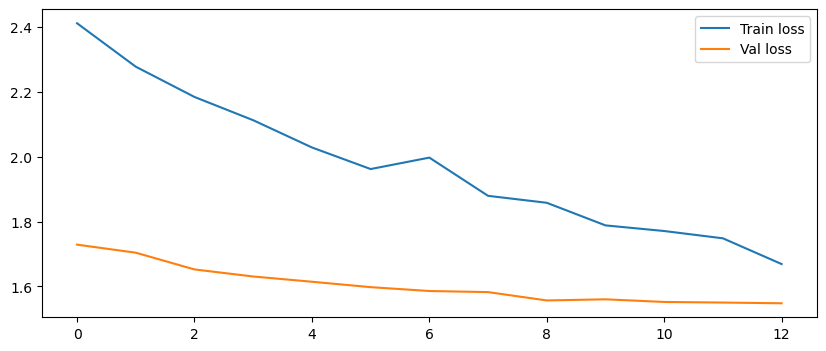

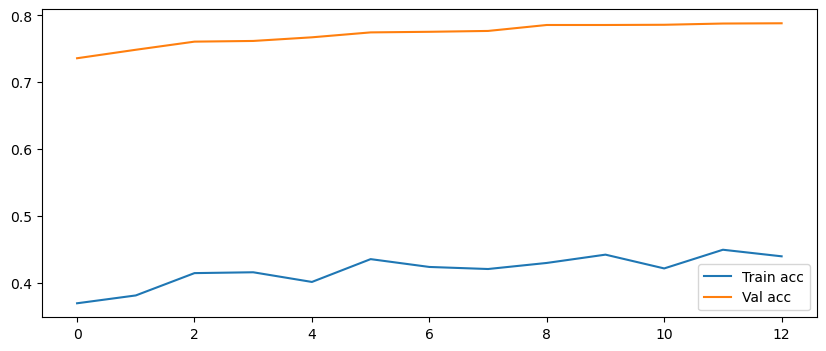

In [11]:
# start from your best probe head weights
ft = ClassifierWithEncoder(build_backbone, enc_state_dict, feat_dim, num_classes)
# warm-start head from the trained probe head if you have it:
try:
    ft.head.load_state_dict(probe.head.state_dict(), strict=True)
    print("Loaded probe head into fine-tune model.")
except Exception:
    pass

# unfreeze last 2 blocks; train BN affine but freeze BN running stats (stable for small batches)
ft.unfreeze_last_k(k=2, bn_affine=True, bn_stats_train=False)

# try 10–15 epochs; head lr 5e-4, encoder lr 5e-5 (10× smaller)
ft, ft_hist = fine_tune(
    ft, cls_train_loader, cls_val_loader,
    epochs=13, lr_head=1e-3, lr_enc=1e-4,
    mixup_alpha=0.2, mixup_alpha_end=0.05,   # decay mixup late
    cutmix_alpha=1.0, p_cutmix=0.1
)

plt.figure(figsize=(10,4))
plt.plot([h[0] for h in ft_hist], label='Train loss')
plt.plot([h[2] for h in ft_hist], label='Val loss')
plt.legend(); plt.show()
plt.figure(figsize=(10,4))
plt.plot([h[1] for h in ft_hist], label='Train acc')
plt.plot([h[3] for h in ft_hist], label='Val acc')
plt.legend(); plt.show()


FT 1/12:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  1/12 | Train 2.0313/0.4368 | Val 1.5716/0.7797 | LR(enc/head) [5e-05, 5e-05, 0.0005]


FT 2/12:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  2/12 | Train 2.0255/0.4377 | Val 1.5488/0.7882 | LR(enc/head) [4.898732434036244e-05, 4.898732434036244e-05, 0.0004898732434036243]


FT 3/12:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  3/12 | Train 1.9829/0.4134 | Val 1.5512/0.7882 | LR(enc/head) [4.6031338320779534e-05, 4.6031338320779534e-05, 0.0004603133832077953]


FT 4/12:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  4/12 | Train 1.9473/0.4407 | Val 1.5426/0.7886 | LR(enc/head) [4.137151834863213e-05, 4.137151834863213e-05, 0.0004137151834863213]


FT 5/12:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  5/12 | Train 1.9085/0.4569 | Val 1.5301/0.7918 | LR(enc/head) [3.5385375325047166e-05, 3.5385375325047166e-05, 0.00035385375325047166]


FT 6/12:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  6/12 | Train 1.8482/0.4385 | Val 1.5291/0.7923 | LR(enc/head) [2.8557870956832132e-05, 2.8557870956832132e-05, 0.00028557870956832135]


FT 7/12:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  7/12 | Train 1.7991/0.4433 | Val 1.5371/0.7893 | LR(enc/head) [2.1442129043167874e-05, 2.1442129043167874e-05, 0.00021442129043167875]


FT 8/12:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  8/12 | Train 1.7334/0.4679 | Val 1.5257/0.7935 | LR(enc/head) [1.4614624674952842e-05, 1.4614624674952842e-05, 0.0001461462467495284]


FT 9/12:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  9/12 | Train 1.7364/0.4496 | Val 1.5184/0.7939 | LR(enc/head) [8.628481651367872e-06, 8.628481651367872e-06, 8.628481651367872e-05]


FT 10/12:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch 10/12 | Train 1.7221/0.4938 | Val 1.5203/0.7939 | LR(enc/head) [3.968661679220468e-06, 3.968661679220468e-06, 3.968661679220467e-05]


FT 11/12:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch 11/12 | Train 1.6372/0.4529 | Val 1.5163/0.7953 | LR(enc/head) [1.0126756596375686e-06, 1.0126756596375686e-06, 1.0126756596375685e-05]


FT 12/12:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch 12/12 | Train 1.5812/0.4691 | Val 1.5202/0.7940 | LR(enc/head) [0.0, 0.0, 0.0]
Val (A): {'top1': 0.7991803278688525, 'top5': 0.9302638319672131, 'f1': 0.8032674241347576, 'precision': 0.8151733556530066, 'recall': 0.7991803278688525}


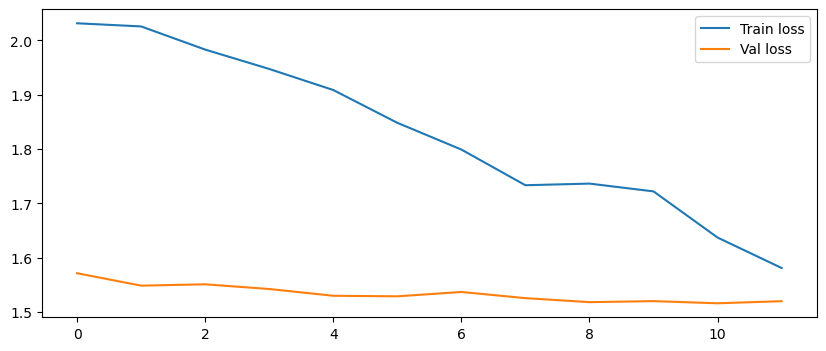

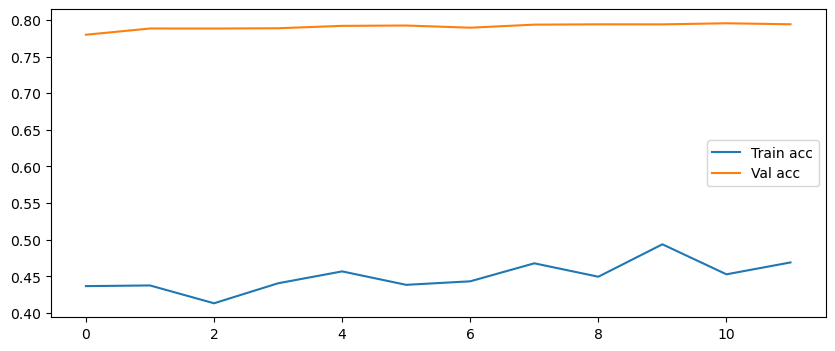

In [12]:
# continue from your 'ft' model after loading probe head
ft.unfreeze_last_k(k=3, bn_affine=True, bn_stats_train=False)

ft, histA = fine_tune(
    ft, cls_train_loader, cls_val_loader,
    epochs=12,
    lr_head=5e-4, lr_enc=5e-5,
    mixup_alpha=0.2, mixup_alpha_end=0.05,   # decay mixup late
    cutmix_alpha=1.0, p_cutmix=0.1
)

valA = evaluate_classifier(ft, cls_val_loader, classes=[idx2label[i] for i in range(num_classes)], tta_hflip=True)
print("Val (A):", valA)

plt.figure(figsize=(10,4))
plt.plot([h[0] for h in histA], label='Train loss')
plt.plot([h[2] for h in histA], label='Val loss')
plt.legend(); plt.show()
plt.figure(figsize=(10,4))
plt.plot([h[1] for h in histA], label='Train acc')
plt.plot([h[3] for h in histA], label='Val acc')
plt.legend(); plt.show()


FT 1/10:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  1/10 | Train 1.9719/0.4642 | Val 1.5620/0.7862 | LR(enc/head) [9e-05, 9e-05, 0.0009]


FT 2/10:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  2/10 | Train 1.9932/0.4354 | Val 1.5308/0.7919 | LR(enc/head) [8.728616793536588e-05, 8.728616793536588e-05, 0.0008728616793536588]


FT 3/10:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  3/10 | Train 1.9158/0.4578 | Val 1.5181/0.7965 | LR(enc/head) [7.947199994035401e-05, 7.947199994035401e-05, 0.00079471999940354]


FT 4/10:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  4/10 | Train 1.8924/0.4637 | Val 1.5229/0.7943 | LR(enc/head) [6.75e-05, 6.75e-05, 0.000675]


FT 5/10:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  5/10 | Train 1.8450/0.4727 | Val 1.5035/0.8039 | LR(enc/head) [5.2814167995011876e-05, 5.2814167995011876e-05, 0.0005281416799501188]


FT 6/10:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  6/10 | Train 1.7511/0.4802 | Val 1.5003/0.8034 | LR(enc/head) [3.7185832004988136e-05, 3.7185832004988136e-05, 0.0003718583200498814]


FT 7/10:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  7/10 | Train 1.7019/0.4862 | Val 1.4971/0.8036 | LR(enc/head) [2.250000000000001e-05, 2.250000000000001e-05, 0.0002250000000000001]


FT 8/10:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  8/10 | Train 1.6420/0.4802 | Val 1.4913/0.8038 | LR(enc/head) [1.0528000059645995e-05, 1.0528000059645995e-05, 0.00010528000059645994]


FT 9/10:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch  9/10 | Train 1.5762/0.4794 | Val 1.4907/0.8065 | LR(enc/head) [2.7138320646341257e-06, 2.7138320646341257e-06, 2.7138320646341256e-05]


FT 10/10:   0%|          | 0/1172 [00:00<?, ?it/s]

Epoch 10/10 | Train 1.5766/0.4884 | Val 1.4898/0.8042 | LR(enc/head) [0.0, 0.0, 0.0]
Val (B): {'top1': 0.809234118852459, 'top5': 0.934234118852459, 'f1': 0.8123490734744802, 'precision': 0.8225755057486756, 'recall': 0.809234118852459}
Test (B): {'top1': 0.8077366465992059, 'top5': 0.9319200717304983, 'f1': 0.8113468493423692, 'precision': 0.822904249726467, 'recall': 0.8077366465992059}


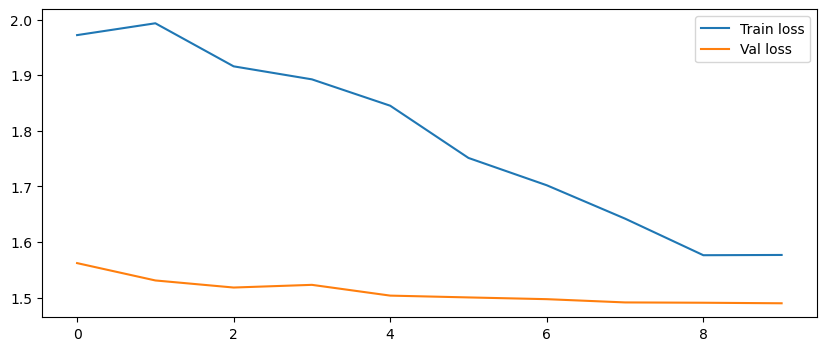

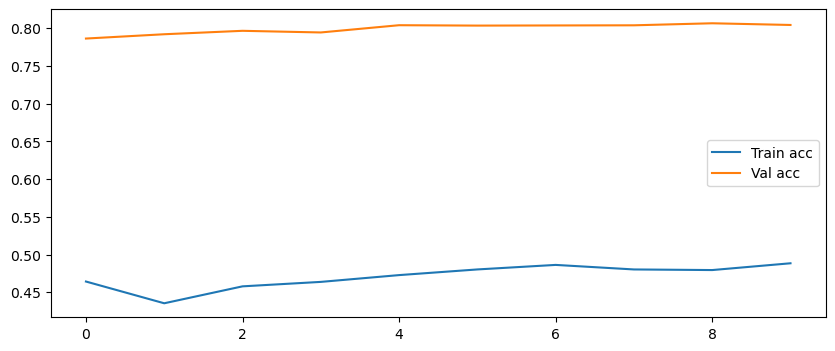

In [15]:
ft.unfreeze_all(bn_affine=True, bn_stats_train=False)

ft, histB = fine_tune(
    ft, cls_train_loader, cls_val_loader,
    epochs=10,
    lr_head=9e-4, lr_enc=9e-5,               # 10× ratio stays
    mixup_alpha=0.15, mixup_alpha_end=0.0,   # turn off by the end to sharpen
    cutmix_alpha=1.0, p_cutmix=0.20
)

valB  = evaluate_classifier(ft, cls_val_loader,  classes=[idx2label[i] for i in range(num_classes)], tta_hflip=True)
testB = evaluate_classifier(ft, cls_test_loader, classes=[idx2label[i] for i in range(num_classes)], tta_hflip=True)
print("Val (B):",  valB)
print("Test (B):", testB)

plt.figure(figsize=(10,4))
plt.plot([h[0] for h in histB], label='Train loss')
plt.plot([h[2] for h in histB], label='Val loss')
plt.legend(); plt.show()
plt.figure(figsize=(10,4))
plt.plot([h[1] for h in histB], label='Train acc')
plt.plot([h[3] for h in histB], label='Val acc')
plt.legend(); plt.show()


In [16]:
classes = [idx2label[i] for i in range(num_classes)]
val_metrics  = evaluate_classifier(ft, cls_val_loader,  classes)
test_metrics = evaluate_classifier(ft, cls_test_loader, classes)
print("Val:",  val_metrics)
print("Test:", test_metrics)

Val: {'top1': 0.809234118852459, 'top5': 0.934234118852459, 'f1': 0.8123490734744802, 'precision': 0.8225755057486756, 'recall': 0.809234118852459}
Test: {'top1': 0.8077366465992059, 'top5': 0.9319200717304983, 'f1': 0.8113468493423692, 'precision': 0.822904249726467, 'recall': 0.8077366465992059}


In [17]:
ft_sd = {k: v.detach().cpu() for k, v in ft.state_dict().items()}
torch.save(ft_sd, "bird2vec2label.pth")